# Datos de la Actividad

***Actividad 2.2:*** Redes Neuronales para Reconocimiento de Rostros

***Elaborado por:*** León Emiliano García Pérez [A00573074] y José Ángel Tobón Salazar [A00573074] + Asistidos / Guiados por IA en el Desarrollo del Presente (Como los GPT para entendimiento de Código Ejemplo + Gemini + Copilot para Limpieza, Optimización y Resoluciones de Errores en nuestro Desarrollo de Código)

***Fecha de Entrega:*** Jueves 2 de Mayo de 2024

In [ ]:
#Conexión con Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ejemplo del Profesor

In [ ]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import math

# Choosing which GPU this notebook can access
# (useful when running multiple experiments in parallel, on different GPUs):
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

# Some hyper-parameters:
input_shape = [224, 224, 3] # We will resize the input images to this shape
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 10            # Max number of training epochs
random_seed = 22            # Seed for some random operations, for reproducibility - NOTA: SE AJUST

In [ ]:
import cifar_utils

cifar_info = cifar_utils.get_info()
print(cifar_info)

# Number of classes:
num_classes = cifar_info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incomplete2XO7JA/cifar100-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incomplete2XO7JA/cifar100-test.tfrecord*...:   0%|         …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpn38jqf9gtfds'),
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label':

In [ ]:
train_cifar_dataset = cifar_utils.get_dataset(
    phase='train', batch_size=batch_size, num_epochs=num_epochs, shuffle=True,
    input_shape=input_shape, seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset(
    phase='test', batch_size=batch_size, num_epochs=1, shuffle=False,
    input_shape=input_shape, seed=random_seed)

Reusing ResNet-50 from Keras Apps
we will instantiate a ResNet-50 model, with **randomly-initialized parameters**


In [ ]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights=None,
    input_shape=input_shape, classes=num_classes)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Training the Network
Once instantiated, our model from Keras Applications is like any ohter Keras model. Exactly as we did previously, we will train it on CIFAR:

In [ ]:
import collections
import functools
from keras_custom_callbacks import SimpleLogCallback

# Defining a custom metrics (top-5 accuracy), from a more generic one provided by Keras:
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')

metrics_to_print = collections.OrderedDict([("loss", "loss"),
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"),
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"),
                                            ("v-top5-acc", "val_top5_acc")])

# Defining optimizer and callbacks for the training:
optimizer = tf.keras.optimizers.Adam()

model_dir = './models/resnet_keras_app'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model, e.g., every 5 epochs:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1)
]

# Finally, compiling and training:
resnet50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                 metrics=[accuracy_metric, top5_accuracy_metric])

history = resnet50.fit(train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                       validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
                       verbose=1, callbacks=callbacks)

Training: start.
Epoch 1/10
   6/1563 [..............................] - ETA: 1:36 - loss: 8.1383 - acc: 0.0104 - top5_acc: 0.0625

1563/1563 [==============================] - 135s 64ms/step - loss: 4.1851 - acc: 0.0695 - top5_acc: 0.2431 - val_loss: 3.8196 - val_acc: 0.1019 - val_top5_acc: 0.3233
Epoch 2/10
1563/1563 [==============================] - 97s 62ms/step - loss: 3.6494 - acc: 0.1432 - top5_acc: 0.3836 - val_loss: 3.5285 - val_acc: 0.1562 - val_top5_acc: 0.4242
Epoch 3/10
1563/1563 [==============================] - 97s 62ms/step - loss: 3.2684 - acc: 0.2059 - top5_acc: 0.4867 - val_loss: 3.1249 - val_acc: 0.2380 - val_top5_acc: 0.5324
Epoch 4/10
1563/1563 [==============================] - 97s 62ms/step - loss: 2.8360 - acc: 0.2844 - top5_acc: 0.5931 - val_loss: 2.9103 - val_acc: 0.3130 - val_top5_acc: 0.6169
Epoch 5/10
1563/1563 [==============================] - ETA: 0s - loss: 2.4508 - acc: 0.3647 - top5_acc: 0.6815

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch  4/10: loss = 2.451; v-loss = 2.483; acc = 0.365; v-acc = 0.371; top5-acc = 0.681; v-top5-acc = 0.680
1563/1563 [==============================] - 98s 63ms/step - loss: 2.4508 - acc: 0.3647 - top5_acc: 0.6815 - val_loss: 2.4830 - val_acc: 0.3706 - val_top5_acc: 0.6804
Epoch 6/10
1563/1563 [==============================] - 97s 62ms/step - loss: 2.1667 - acc: 0.4245 - top5_acc: 0.7412 - val_loss: 2.1471 - val_acc: 0.4333 - val_top5_acc: 0.7398
Epoch 7/10
1563/1563 [==============================] - 97s 62ms/step - loss: 1.9489 - acc: 0.4727 - top5_acc: 0.7845 - val_loss: 2.0969 - val_acc: 0.4551 - val_top5_acc: 0.7561
Epoch 8/10
1563/1563 [==============================] - 97s 62ms/step - loss: 1.7877 - acc: 0.5117 - top5_acc: 0.8124 - val_loss: 1.8015 - val_acc: 0.5157 - val_top5_acc: 0.8118
Epoch 9/10
1563/1563 [==============================] - 97s 62ms/step - loss: 1.6142 - acc: 0.5516 - top5_acc: 0.8386 - val_loss: 1.7498 - val_acc: 0.5266 - val_top5_acc: 0.8144
Epoch 10/10
1

Epoch  9/10: loss = 1.473; v-loss = 1.685; acc = 0.586; v-acc = 0.553; top5-acc = 0.865; v-top5-acc = 0.831
1563/1563 [==============================] - 98s 62ms/step - loss: 1.4727 - acc: 0.5863 - top5_acc: 0.8650 - val_loss: 1.6851 - val_acc: 0.5525 - val_top5_acc: 0.8305
Training: end.


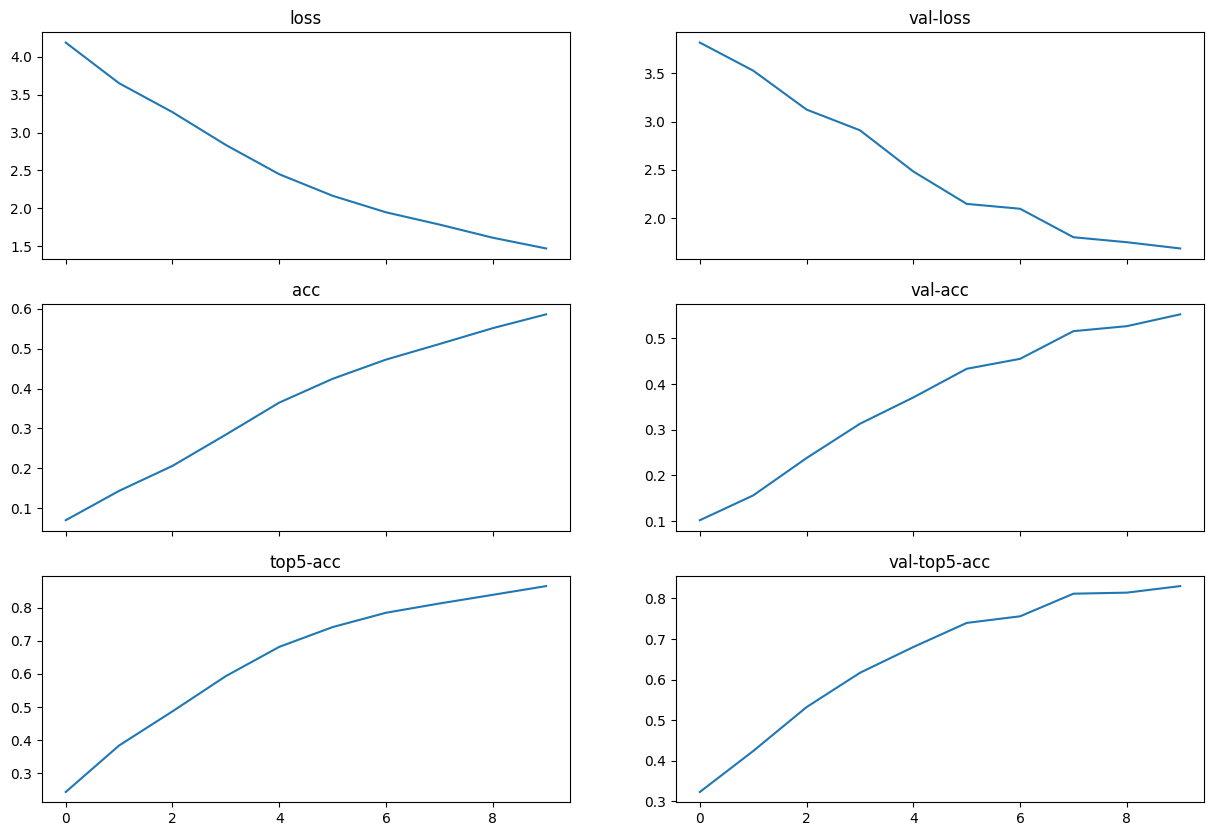

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])
ax[2, 0].plot(history.history['top5_acc'])
ax[2, 1].plot(history.history['val_top5_acc'])

# Fine Tunning para Reconocimiento de Rostros

Importamos todas las librerías necesarias desde un principio

In [9]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from PIL import Image
import collections
from keras_custom_callbacks import SimpleLogCallback
import cifar_utils
import functools

Preprocesamiento

In [10]:
# Función para Preprocesamiento de las imágenes
def preprocess_image(image, label):

    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    image = image / 255.0
    people_classes = tf.constant([2, 11, 35, 46, 98], dtype=tf.int64)  # índices / Etiquetas que presentan caras
    label = tf.cast(label, tf.int64)
    is_person = tf.reduce_any(tf.equal(label, people_classes))

    return image, is_person

# Cargamos el Conjunto de Datos CIFAR-100
dataset, info = tfds.load('cifar100', split=['train', 'test'], with_info=True, as_supervised=True)
train_data, test_data = dataset

# Definimos Forma de Entrada y el Tamaño del Batch
input_shape = (224, 224, 3)
batch_size = 32

# Preprocesamiento
train_dataset = train_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = test_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

Mostramos algunas de las imágenes que el modelo reconocerá

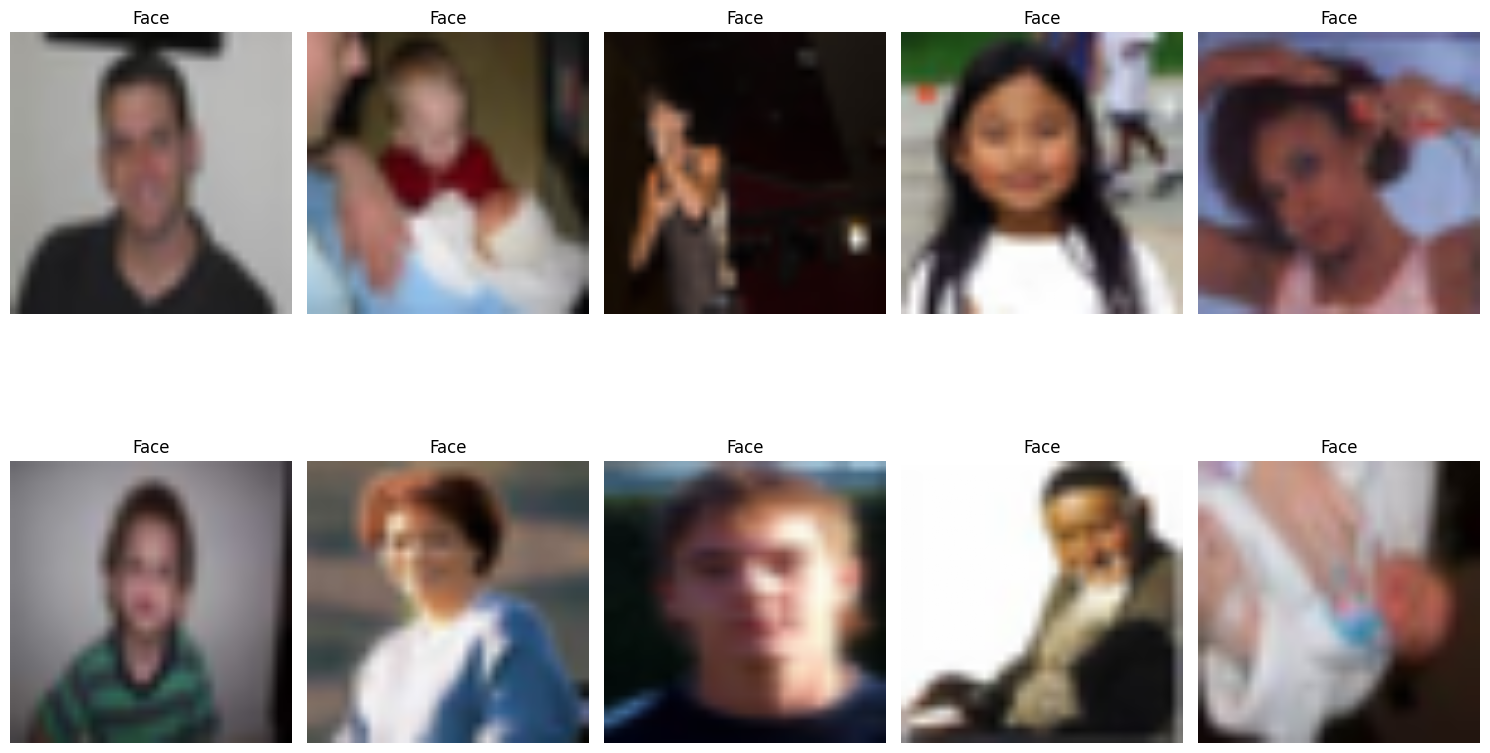

In [11]:
# Función Mostrar algunas imágenes de caras con las que vamos a trabajar
def display_face_images(dataset, people_classes, num_images=10):

    face_images = []
    face_labels = []


    for images, is_person in dataset:

        for image, person in zip(images.numpy(), is_person.numpy()):

            if person and len(face_images) < num_images:
                face_images.append(image)
                face_labels.append(person)

            if len(face_images) >= num_images:
                break

        if len(face_images) >= num_images:
            break

    # Ploteamos las imágenes
    plt.figure(figsize=(15, 10))

    for i, image in enumerate(face_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title('Face')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Índices / Etiquetas que son definidos como "Personas" y que presentan caras
people_classes = tf.constant([2, 11, 35, 46, 98], dtype=tf.int64)

# Aplicamos al validation_dataset (con el que entranaremos, train_dataset)
display_face_images(validation_dataset, people_classes, 10)

Realizamos Fine-Tunning - ResNet50 + CIFAR100

In [13]:
# Definimos el modelo base (ResNet50 preentrenado en CIFAR)
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# Número de Clases
cifar_info = cifar_utils.get_info()
num_classes = cifar_info.features['label'].num_classes

# Congelamiento de los Pesos del Modelo Base
for layer in base_model.layers:
    layer.trainable = False

# Añadimos Nuevas Capas al Final del Modelo
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Creamos el Neuvo Modelo
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Definimos métricoas para Top 5 Accuracy, apoyados de Keras
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')

# Compilams el Modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[accuracy_metric,top5_accuracy_metric])

# Entrenamos el modelo con el Conjunto de Datos para Reconocimiento Facial
history2 = model.fit(train_dataset, epochs=50, verbose=2, validation_data=validation_dataset)

# Evaluate the model on the validation dataset - Evaluamos el Modelo con el DataSet de Validación
results = model.evaluate(validation_dataset)

# Resultados
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test Top-5 Accuracy: {results[2]}")

Epoch 1/50
1563/1563 - 45s - loss: 0.2135 - acc: 0.9494 - top5_acc: 0.9994 - val_loss: 0.1971 - val_acc: 0.9500 - val_top5_acc: 1.0000 - 45s/epoch - 29ms/step
Epoch 2/50
1563/1563 - 38s - loss: 0.2011 - acc: 0.9500 - top5_acc: 1.0000 - val_loss: 0.1968 - val_acc: 0.9500 - val_top5_acc: 1.0000 - 38s/epoch - 24ms/step
Epoch 3/50
1563/1563 - 38s - loss: 0.1998 - acc: 0.9500 - top5_acc: 1.0000 - val_loss: 0.1967 - val_acc: 0.9500 - val_top5_acc: 1.0000 - 38s/epoch - 24ms/step
Epoch 4/50
1563/1563 - 37s - loss: 0.1988 - acc: 0.9500 - top5_acc: 1.0000 - val_loss: 0.1966 - val_acc: 0.9500 - val_top5_acc: 1.0000 - 37s/epoch - 24ms/step
Epoch 5/50
1563/1563 - 38s - loss: 0.1981 - acc: 0.9500 - top5_acc: 1.0000 - val_loss: 0.1967 - val_acc: 0.9500 - val_top5_acc: 1.0000 - 38s/epoch - 24ms/step
Epoch 6/50
1563/1563 - 38s - loss: 0.1976 - acc: 0.9500 - top5_acc: 1.0000 - val_loss: 0.1962 - val_acc: 0.9500 - val_top5_acc: 1.0000 - 38s/epoch - 24ms/step
Epoch 7/50
1563/1563 - 38s - loss: 0.1970 - ac

Obtenemos un Test Loss de 0.175 y un Test Accuracy de 0.949

Graficamos el resultante

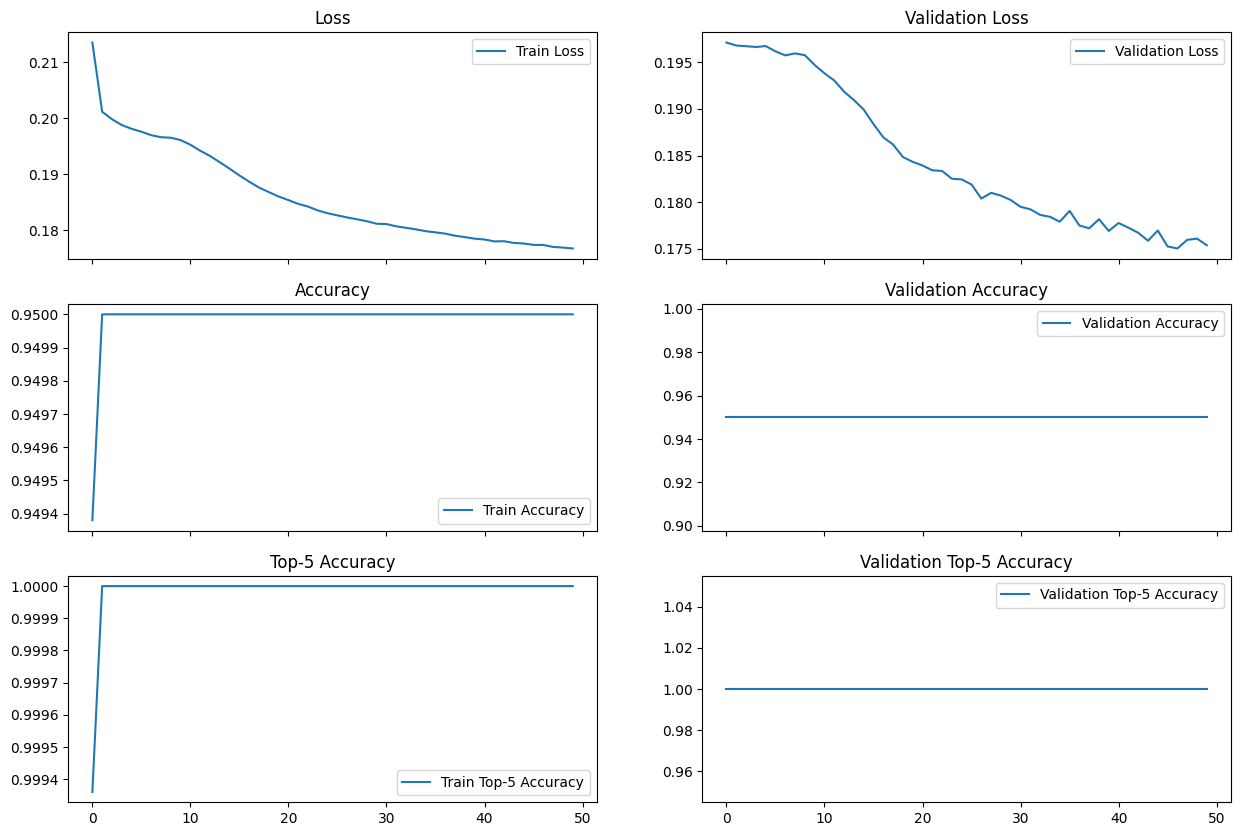

In [14]:
# Ploteo de las Métricas de Entrenamiento y Validación

fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col')

ax[0, 0].set_title("Loss")
ax[0, 1].set_title("Validation Loss")
ax[1, 0].set_title("Accuracy")
ax[1, 1].set_title("Validation Accuracy")
ax[2, 0].set_title("Top-5 Accuracy")
ax[2, 1].set_title("Validation Top-5 Accuracy")

ax[0, 0].plot(history2.history['loss'], label='Train Loss')
ax[0, 1].plot(history2.history['val_loss'], label='Validation Loss')
ax[1, 0].plot(history2.history['acc'], label='Train Accuracy')
ax[1, 1].plot(history2.history['val_acc'], label='Validation Accuracy')
ax[2, 0].plot(history2.history['top5_acc'], label='Train Top-5 Accuracy')
ax[2, 1].plot(history2.history['val_top5_acc'], label='Validation Top-5 Accuracy')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[2, 0].legend()
ax[2, 1].legend()

plt.show()